In [1]:
import scipy as sp  #scientific computer package
import numpy as np   #math and array package
from numpy import exp, sqrt, pi, log, array   #math functions
import matplotlib.pyplot as plt  #plotting package
from openpyxl import load_workbook  #excel interface package
import xgboost as xgb
from xgboost import XGBRegressor
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from math import sqrt

dvs_data = pd.read_excel('./ChemRev_Hydration_Data.xlsx', sheet_name='HydrationData',usecols = 'A:R')   #importing experimental data


c:\Users\andyt\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\andyt\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [2]:
#not_include = ['Study','Year','Membrane','Cast','LV','RH_r','Pret_Time'] 
exp_features = ['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id']
not_include = ['Cast','LV','RH_r','Pret_Time'] 
# dvs_data.drop(dvs_data[dvs_data['LV_id'] == 0.5].index, inplace = True)
dvs_data = dvs_data.query('Study != "Alberti" and EW == 1100')
df = dvs_data.drop(not_include, axis=1)
df = df[df['Thickness'].notnull()] # Dropping: Pineri-1985 N1200-Cast Low temperature Vapor data: 31 entries

df_1_columns = df.columns.values.tolist()
df_1_columns.remove('Equilibrium_hr')
df_1 = df[df_1_columns]
print('dataset 1: ', df_1.shape)
df_1_l = df_1[df_1['LV_id']==1]  # real liquid
df_1_l['RH'] = df_1_l['RH'].replace(100.1,100)
df_1_v = df_1[df_1['LV_id']==0]  # real vapor
print('dataset 1_l: ', df_1_l.shape)
print('dataset 1_v: ', df_1_v.shape)

df_2 = df[df['Equilibrium_hr'].notnull()] # original data where EQhr is not null 
print('dataset 2: ', df_2.shape)
df_2_l = df_2[df_2['LV_id']==1] 
df_2_v = df_2[df_2['LV_id']==0] 
print('dataset 2_l: ', df_2_l.shape)
print('dataset 2_v: ', df_2_v.shape)


dataset 1:  (621, 13)
dataset 1_l:  (144, 13)
dataset 1_v:  (469, 13)
dataset 2:  (462, 14)
dataset 2_l:  (117, 14)
dataset 2_v:  (337, 14)


C:\Users\andyt\AppData\Local\Temp/ipykernel_36252/637073439.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_l['RH'] = df_1_l['RH'].replace(100.1,100)


In [3]:
def impute_vapor(df, pertinent_features):
    df = df[pertinent_features+["lambda"]] 
    df_v = df[df['LV_id']==0] 
    df_v = df_v[df_v['RH'] > 95]    # we found imputing on High RH produce more accurate results
    df_l = df[df['LV_id']==1]
    df_imaginary_v = df_l.copy() 
    df_imaginary_v['lambda']= None 
    df_toImpute = pd.concat([df_imaginary_v, df_v], ignore_index=True) 
    overlap = pd.merge(df_imaginary_v, df_v, on=pertinent_features, how = 'inner')
    print("Overlap between imaginary vapor and real vapor:")
    print(df_toImpute[pertinent_features].apply(tuple, axis = 1).isin(overlap[pertinent_features].apply(tuple, axis = 1)).value_counts())
    


    counts = df_toImpute['lambda'].isna().value_counts()
    print(df_v.shape)
    print(counts)
    naRatio = counts[1]/(counts[0]+counts[1]) # the percentage of NAN entries (that require imputation)
    print(f"ratio of Nan lambdas:{naRatio}")
    # Knn parameter optimization:
    df_copy = df_v.copy()
    sampled_indices = np.random.choice(df_v.index, size=int(naRatio * len(df_v)), replace=False)
    df_copy.loc[sampled_indices, 'lambda'] = np.nan
    
    n_neighbors_range = range(3, 16)
    rmse_values = []

    for n_neighbors in n_neighbors_range:
        # Perform k-NN imputation on the "lambda" column
        knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
        df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_copy), columns=df_v.columns)

        # Calculate the RMSE between the original and imputed "lambda" values
        rmse = sqrt(mean_squared_error(df_v['lambda'], df_imputed['lambda']))
        rmse_values.append(rmse)

    optimal_n_neighbors = n_neighbors_range[np.argmin(rmse_values)] # selecting the number of neighbors contributing to minimum RMSE between imputed and actual
    print(f"rmse: {rmse_values}")
    # plot
    plt.plot(n_neighbors_range, rmse_values, marker='o')
    plt.title('RMSE vs n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('RMSE')
    plt.show()



    actual_knn_imputer = KNNImputer(n_neighbors=optimal_n_neighbors, weights='distance')

    reference_id = df_toImpute[df_toImpute['lambda'].isna()].index
    # reference_id = df_l.index
    print(f"dim check: {len(df_toImpute[df_toImpute['lambda'].isna()]) == len(df_l)}")
    imputed_dfv = pd.DataFrame(actual_knn_imputer.fit_transform(df_toImpute), columns=df_toImpute.columns)
    print(f"imputation completion check: {imputed_dfv['lambda'].notna().value_counts()}")

    # comparison of imputed vapor vs real liquid
    #correspondence = pd.merge(df_l, imputed_dfv.loc[reference_id], on=pertinent_features)
    #correspondence['delta_lamda'] = correspondence.lambda_x - correspondence.lambda_y
    correspondence = df_l.copy()
    correspondence['lambda_v'] = imputed_dfv.loc[reference_id]['lambda']
    correspondence['delta_lambda'] = correspondence['lambda'] - correspondence['lambda_v']

    # final combined df of both liquid vapor, and imaginary vapor data for training.
    augmented_df = pd.concat([imputed_dfv,df_l], ignore_index= True)
    #augmented_df['delta_lamda'] = augmented_df.lambda_y - augmented_df.lambda_x

    return correspondence, imputed_dfv.loc[reference_id], augmented_df













def impute_liquid(df, pertinent_features):
    df = df[pertinent_features+["lambda"]]
    df_v = df[df['LV_id']==1] # this is creating fake liquid data
    df_l = df[df['LV_id']==0]
    df_l = df_l[df_l['RH'] > 95]
    df_imaginary_v = df_l.copy() 
    df_imaginary_v['lambda']= None 
    df_toImpute = pd.concat([df_imaginary_v, df_v], ignore_index=True) 
    overlap = pd.merge(df_imaginary_v, df_v, on=pertinent_features, how = 'inner')
    print("Overlap between imaginary vapor and real vapor:")
    print(df_toImpute[pertinent_features].apply(tuple, axis = 1).isin(overlap[pertinent_features].apply(tuple, axis = 1)).value_counts())
    
    counts = df_toImpute['lambda'].isna().value_counts()
    print(df_v.shape)
    print(counts)
    naRatio = counts[1]/(counts[0]+counts[1]) # the percentage of NAN entries (that require imputation)
    print(f"ratio of Nan lambdas:{naRatio}")
    # Knn parameter optimization:
    df_copy = df_v.copy()
    sampled_indices = np.random.choice(df_v.index, size=int(naRatio * len(df_v)), replace=False)
    df_copy.loc[sampled_indices, 'lambda'] = np.nan
    
    n_neighbors_range = range(3, 16)
    rmse_values = []
    
    for n_neighbors in n_neighbors_range:
        # Perform k-NN imputation on the "lambda" column
        knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
        df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_copy), columns=df_v.columns)

        # Calculate the RMSE between the original and imputed "lambda" values
        rmse = sqrt(mean_squared_error(df_v['lambda'], df_imputed['lambda']))
        rmse_values.append(rmse)

    optimal_n_neighbors = n_neighbors_range[np.argmin(rmse_values)] # selecting the number of neighbors contributing to minimum RMSE between imputed and actual
    print(f"rmse: {rmse_values}")
    # plot
    plt.plot(n_neighbors_range, rmse_values, marker='o')
    plt.title('RMSE vs n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('RMSE')
    plt.show()

    actual_knn_imputer = KNNImputer(n_neighbors=optimal_n_neighbors, weights='distance')
    reference_id = df_toImpute[df_toImpute['lambda'].isna()].index
    # reference_id = df_l.index
    print(f"dim check: {len(df_toImpute[df_toImpute['lambda'].isna()]) == len(df_l)}")
    imputed_dfv = pd.DataFrame(actual_knn_imputer.fit_transform(df_toImpute), columns=df_toImpute.columns)
    print(f"imputation completion check: {imputed_dfv['lambda'].notna().value_counts()}")

    # comparison of imputed vapor vs real liquid
    #correspondence = pd.merge(df_l, imputed_dfv.loc[reference_id], on=pertinent_features)
    #correspondence['delta_lamda'] = correspondence.lambda_x - correspondence.lambda_y
    correspondence = df_l.copy()
    correspondence['lambda_v'] = imputed_dfv.loc[reference_id]['lambda']
    correspondence['delta_lambda'] = correspondence['lambda'] - correspondence['lambda_v']

    # final combined df of both liquid vapor, and imaginary vapor data for training.
    augmented_df = pd.concat([imputed_dfv,df_l], ignore_index= True)
    #augmented_df['delta_lamda'] = augmented_df.lambda_y - augmented_df.lambda_x

    return correspondence, imputed_dfv.loc[reference_id], augmented_df

In [5]:
def impute_helper(df, pertinent_features, vapToLiq, train_set):    # a simplified version of impute_vapor
    df = df[pertinent_features+["lambda"]] 
    df_l = df[df['LV_id']==1]
    # construct imputation reference vapor >95 RH
    

    if not vapToLiq:
        # construct sim_vapor
        sim_vap = df_l.copy() 
        sim_vap['lambda']= None 
        df_v_HignRh = train_set.query("LV_id == 0 and RH>95")
        # combine into imputation matrix (liquid-->sim_vap-->impute against high RH vap_exp)
        df_toImpute = pd.concat([sim_vap, df_v_HignRh], ignore_index=True) 

    else:
        # construct sim_liq
        sim_liq = df_v_HignRh.copy()
        sim_liq['lambda']= None
        # combine into imputation matrix (high RH vap_exp-->sim_liq-->impute against liq_exp)
        df_toImpute = pd.concat([sim_liq, train_set], ignore_index=True)  # in this case, capToLiq is liq_exp_train from the calling function

    actual_knn_imputer = KNNImputer(n_neighbors=7, weights='distance')
    imputed_dfv = pd.DataFrame(actual_knn_imputer.fit_transform(df_toImpute), columns=df_toImpute.columns)
    return imputed_dfv  # sim_vapor + real vapor > 95RH





def make_X_y(data_frame, on_features = None, param='lambda'):
    if on_features:
        x_columns = on_features
    else:
        x_columns = data_frame.columns.values.tolist()
        x_columns.remove(y_column)
    y_column = param
    y = data_frame[y_column].values
    X = data_frame[x_columns].values
    return X, y, x_columns



def deltaLambda_check(training_data, pertinent_features):
    training_data.groupby(pertinent_features)

# def conditions(data, feature):
#     high = data[data[feature == 0]]
#     low = data[data[feature == 1]]

#     if high['lambda'].values < low['lambda']:


def validate_imputed(df, regressor_class, on_features:list, return_regressor=True, n_splits = 8, vapToLiq = False, **params):
    df_v = df[df['LV_id']==0] 
    df_l = df[df['LV_id']==1]
    kf = KFold(n_splits, shuffle=True, random_state=1) 
    # Kfold object returns generator equivalent to  {N_splits} dimensional array, each element of the array is a 2 item tuple,
    # the first item of the tuple is the list of train indices, second item is the list of test indices. 
    vap_indices = list(kf.split(df_v))
    liq_indices = list(kf.split(df_l))

    train_scores = list()
    test_scores = list()
    rg_lst = list()

    for s in range(1,n_splits):
        training_id = list(np.arange(1,n_splits+1)).remove(s)

        vap_exp_train = df_v.iloc[vap_indices[s][0]]
        vap_exp_test = df_v.iloc[vap_indices[s][1]]  
        liq_exp_train = df_l.iloc[liq_indices[s][0]]
        liq_exp_test = df_l.iloc[liq_indices[s][1]]  

        test_set = pd.concat([vap_exp_test, liq_exp_test], ignore_index=True)
        send_for_impute = pd.concat([vap_exp_train, df_l], ignore_index=True) 
        # here the data sent for imputation is everything except test_vapor 
        # filtering >95RH withing training_vapor will occur in the imputation helper function
        
        # imputation
        imputed = impute_helper(df, on_features, vapToLiq) # imputed contains real vapor >95RH and sim_vapor

        # construct training set
        # need to append vapor<=95RH and real liquid 
        # in the graph, {training_set} marks the region right of the red line
        if not vapToLiq:
            # imputation
            imputed = impute_helper(df, on_features, vapToLiq, vap_exp_train) # imputed contains real vapor >95RH and sim_vapor
            train_set = pd.concat([imputed, vap_exp_train[vap_exp_train['RH'] <= 95], liq_exp_train], ignore_index=True)
        else:
            imputed = impute_helper(df, on_features, vapToLiq, liq_exp_train) # imputed contains real vapor >95RH and sim_vapor
            train_set = pd.concat([imputed, vap_exp_train], ignore_index=True)
        # make - dtlambda 0 

        X_train, y_train, train_cols = make_X_y(train_set, on_features)
        X_test, y_test, test_cols = make_X_y(test_set, on_features)

        # Model training and eval   
        rg = regressor_class()
        rg.set_params(**params)
        rg.fit(X_train, y_train)
        train_scores.append(rg.score(X_train, y_train))
        test_scores.append(rg.score(X_test, y_test))
        if return_regressor:
            rg_lst.append(rg)

    # final_test_set = pd.concat([df_v.iloc[vap_indices[0][1]], df_l.iloc[liq_indices[0][1]]], ignore_index=True)
    # final_train_set = pd.concat([df_v.iloc[vap_indices[0][:]], df_l.iloc[liq_indices[0][:]]], ignore_index=True)
    # rg = regressor_class()

    print(train_scores)
    print(f'mean train score: {np.round(np.mean(train_scores),4)}  \
          ---  mean test score: {np.round(np.mean(test_scores),4)} ---test min/max: {np.round(min(test_scores),4)} | {np.round(max(test_scores),4)}')
    
    if return_regressor:
        return rg_lst[np.argmax(test_scores)]





def fit_entire_data(df, regressor_class, on_features, print_score = True, **params):
    #imputed = impute_helper(df, on_features)
    #augmented_df = pd.concat([imputed_vap, df.query("LV_id == 0 and RH<=95"), df[df['LV_id']==1]], ignore_index=True)
    X, y, cols = make_X_y(df_1, on_features)
    rg = regressor_class()
    rg.set_params(**params)
    rg.fit(X,y)
    if print_score:
        print(rg.score(X,y))
    return rg


In [12]:
data = pd.DataFrame({
    'A': [1, 1, 2, 2, 3, 3, 3],
    'B': ['X', 'X', 'Y', 'Y', 'Z', 'Z', 'Z'],
    'C': ['P', 'P', 'P', 'Q', 'R', 'U', 'R'],
    'D': [0, 1, 0, 1, 0, 1, 1],
    'E': [10, 15, 20, 25, 30, 35, 40]
})
data['features'] = data['A'].astype(str) + '-' + data['B'].astype(str) + '-' + data['C']
data.drop(['A','B','C'], axis = 1, inplace = True)
data_v = data[data['D']==1]
data_l = data[data['D']==0]
reference = data.groupby(['features']).count()
reference

,D,E
features,,
1-X-P,2,2
2-Y-P,1,1
2-Y-Q,1,1
3-Z-R,2,2
3-Z-U,1,1


In [108]:
c = exp_features + ['RH']
d = exp_features + ['lambda']
df[d].groupby(exp_features).count().to_excel('duplicates.xlsx')

In [99]:
to_check_v = 
to_check_v 
for 

,D,E
features,,
1-X-P,1,15
2-Y-Q,1,25
3-Z-R,1,40
3-Z-U,1,35


In [60]:
rg_partial = validate_imputed(df_1, XGBRegressor, on_features=exp_features, n_splits=6)

[0.9936111029538944, 0.9930042337189903, 0.9936286115443979, 0.994336161231497, 0.9946332190749243, 0.9927979317804498]
mean train score: 0.9937            ---  mean test score: 0.9417 ---test min/max: 0.9156 | 0.9639


In [62]:
rg_full = fit_entire_data(df_1, RandomForestRegressor, on_features=exp_features)

0.9891489599149138


In [30]:
imputed_vap = impute_helper(df, exp_features)
augmented_df = pd.concat([imputed_vap, df.query("LV_id == 0 and RH<=95"), df[df['LV_id']==1]], ignore_index=True)
X, y, cols = make_X_y(augmented_df, exp_features)

print(rg_partial.score(X,y))

0.7809287364271057


In [6]:
data = {
    'A': [1, 1, 2, 2, 3, 3, 3],
    'B': ['X', 'X', 'Y', 'Y', 'Z', 'Z', 'Z'],
    'C': ['P', 'P', 'Q', 'Q', 'R', 'R', 'R'],
    'D': [0, 1, 0, 1, 0, 1, 1],
    'E': [10, 15, 20, 25, 30, 35, 40]
}

df = pd.DataFrame(data)

# Function to apply the specified condition
def modify_e_values(group):
    if len(group['D'].unique()) == 2:
        d0_row = group[group['D'] == 0]
        d1_row = group[group['D'] == 1]

        if d1_row['E'].values < d0_row['E'].values:
            d1_row['E'] = d0_row['E'].values

    return group

# Apply the function to the DataFrame grouped by columns A, B, C
df_modified = df.groupby(['A', 'B', 'C']).apply(modify_e_values)

# Reset index to clean up the DataFrame
df_modified.reset_index(drop=True, inplace=True)

# Display the modified DataFrame
print(df_modified)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## exp_features = ['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id']

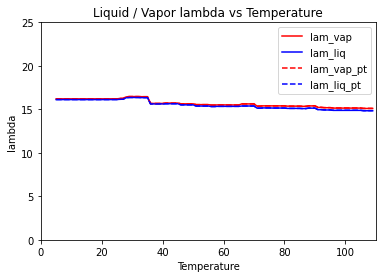

In [78]:
def chem_pot(rh,T):
    return 8.314*(T+273.15)*np.log(rh+0.01/100)

ew = 1100
cast = 1
thickness = 175
pt = 0
drying_temp = 70;
Eq_hr = 2
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
X_vap = [[ew,cast,thickness,0,drying_temp,t,100,0] for t in temp_range]
lam_vap = rg_partial.predict(X_vap)
X_liq = [[ew,cast,thickness,0,drying_temp,t,100,1] for t in temp_range]
lam_liq = rg_partial.predict(X_liq)
#group2
temp_range = np.arange(5,110,1)
X_vap1 = [[ew,cast,thickness,1,drying_temp,t,100,0] for t in temp_range]
lam_vap1 = rg_partial.predict(X_vap1)
X_liq1 = [[ew,cast,thickness,1,drying_temp,t,100,1] for t in temp_range]
lam_liq1 = rg_partial.predict(X_liq1)



lam_liq - lam_vap;
plt.plot(temp_range, lam_vap, label='lam_vap', color='red')
plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')

# experimental data scatter
#plt.scatter(pt_liq.Temperature, pt_liq['lambda'],color = 'red')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([0,110])
plt.title('Liquid / Vapor lambda vs Temperature')
plt.legend()

In [85]:
df_1

,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
155,Broka,1997,N117,1100,1,175.0,1,120,22.0,0.0,99.0,14.500000,11270.128798
156,Broka,1997,N117,1100,1,175.0,1,120,25.0,0.0,99.0,14.000000,11384.740277
157,Broka,1997,N117,1100,1,175.0,1,120,30.0,0.0,99.0,12.500000,11575.759410
158,Broka,1997,N117,1100,1,175.0,1,120,36.0,0.0,99.0,10.500000,11804.982368
159,Broka,1997,N117,1100,1,175.0,1,120,44.0,0.0,99.0,10.000000,12110.612980
...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,60.0,4.530136,10144.033446
811,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,70.0,5.303879,10525.952854
812,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,80.0,6.430028,10856.786493
813,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,90.0,7.734861,11148.602445


## exp_features = ['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id']

165
0


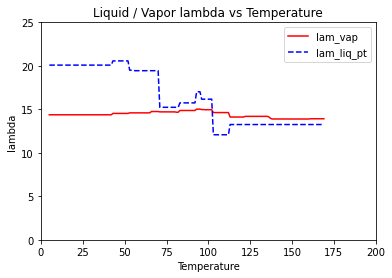

In [84]:
ew = 1100
cast = 1
thickness = 175
pt = 0
drying_temp = 25;
Eq_hr = 2
rh=100
#group 1
temp_range = np.arange(5,170,1)
X_vap = [[ew,cast,thickness,1,ttt,25,rh,0] for ttt in temp_range] # no pt
# X_vap_test = [[ew,cast,thickness,pt,t,t,0,95,chem_pot(95,t),Eq_hr] \
#               for t in plot_range]
lam_vap = rg_full.predict(X_vap)

X_liq1 = [[ew,cast,thickness,1,ttt,25,rh,1] for ttt in temp_range]
lam_liq1 = rg_full.predict(X_liq1)
print(len(temp_range))
print(len(lam_vap)-len(temp_range))
plt.plot(temp_range, lam_vap, label='lam_vap', color='red') # no PT, solid
# plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
# plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([0,200])
plt.title('Liquid / Vapor lambda vs Temperature')
plt.legend()

Overlap between imaginary vapor and real vapor:
False    185
dtype: int64
(144, 9)
False    144
True      41
Name: lambda, dtype: int64
ratio of Nan lambdas:0.22162162162162163
rmse: [1.249578815047753, 1.1405956786936684, 1.1196336122017305, 1.1038786422117892, 1.0560186481633365, 1.0246033038910445, 1.0255121609488143, 1.0285585311602592, 1.0088918713485848, 0.9997557713717342, 1.0086486299699515, 1.0154411565570443, 1.0176535803344424]


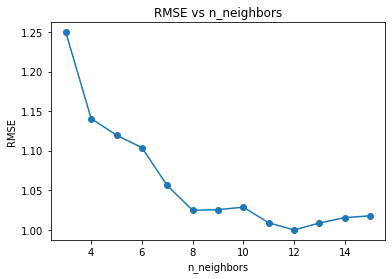

dim check: True
imputation completion check: True    185
Name: lambda, dtype: int64


In [34]:
reverse_imputation = impute_liquid(df_1, exp_features)[1]

In [178]:
imputed_lam = np.array(reverse_imputation['lambda'])
imputed_lam

In [181]:
df_1_v["imputed_lambda"] = imputed_lam
df_1_v

C:\Users\andyt\AppData\Local\Temp/ipykernel_10828/3122475458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_v["imputed_lambda"] = imputed_lam


,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,imputed_lambda
155,Broka,1997,N117,1100,1,175.0,1,120,22.0,0.0,99.0,14.500000,11270.128798,NaN
156,Broka,1997,N117,1100,1,175.0,1,120,25.0,0.0,99.0,14.000000,11384.740277,NaN
157,Broka,1997,N117,1100,1,175.0,1,120,30.0,0.0,99.0,12.500000,11575.759410,NaN
158,Broka,1997,N117,1100,1,175.0,1,120,36.0,0.0,99.0,10.500000,11804.982368,NaN
159,Broka,1997,N117,1100,1,175.0,1,120,44.0,0.0,99.0,10.000000,12110.612980,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,60.0,4.530136,10144.033446,NaN
811,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,70.0,5.303879,10525.952854,NaN
812,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,80.0,6.430028,10856.786493,NaN
813,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,90.0,7.734861,11148.602445,NaN


In [174]:
pd.merge(df_1_v, reverse_imputation, how="inner")

,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential


Overlap between imaginary vapor and real vapor:
False    621
dtype: int64
(477, 9)
False    477
True     144
Name: lambda, dtype: int64
ratio of Nan lambdas:0.2318840579710145
rmse: [0.6732666034196864, 0.6674004709455715, 0.6793662321516435, 0.6722828657854137, 0.6759340737713168, 0.6692717402687024, 0.6642769760616346, 0.6693730337096384, 0.6840029587576538, 0.6960261020644806, 0.7045578861250188, 0.7176752337842048, 0.7281206334111369]


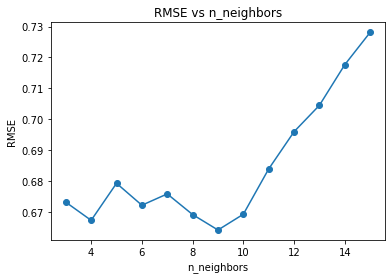

dim check: True
imputation completion check: True    621
Name: lambda, dtype: int64


,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,RH,LV_id,lambda
0,1100.0,1.0,175.0,1.0,105.0,25.0,100.1,1.0,14.497412
1,1100.0,1.0,175.0,1.0,105.0,40.0,100.1,1.0,13.260456
2,1100.0,1.0,175.0,1.0,105.0,50.0,100.1,1.0,16.098279
3,1100.0,1.0,175.0,1.0,105.0,70.0,100.1,1.0,15.925169
4,1100.0,1.0,175.0,1.0,105.0,80.0,100.1,1.0,19.351330
...,...,...,...,...,...,...,...,...,...
139,1100.0,1.0,175.0,1.0,105.0,65.0,100.1,1.0,18.001492
140,1100.0,1.0,175.0,1.0,105.0,85.0,100.1,1.0,16.732725
141,1100.0,1.0,175.0,1.0,25.0,27.0,100.1,1.0,13.277258
142,1100.0,1.0,175.0,1.0,25.0,65.0,100.1,1.0,10.670026


In [157]:
impute_vapor(df_1, exp_features)[1]

In [126]:
df_1_l

,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
181,Hinatsu,1994,N117,1100,1,175.0,1,105,25.0,1.0,100.0,11.0,11412.117042
182,Hinatsu,1994,N117,1100,1,175.0,1,105,40.0,1.0,100.0,12.0,11986.552464
183,Hinatsu,1994,N117,1100,1,175.0,1,105,50.0,1.0,100.0,13.0,12369.509411
184,Hinatsu,1994,N117,1100,1,175.0,1,105,70.0,1.0,100.0,15.0,13135.423307
185,Hinatsu,1994,N117,1100,1,175.0,1,105,80.0,1.0,100.0,18.0,13518.380255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,Zawodzinski,1993,N117,1100,1,175.0,1,105,65.0,1.0,100.0,15.2,12943.944833
767,Zawodzinski,1993,N117,1100,1,175.0,1,105,85.0,1.0,100.0,15.9,13709.858728
768,Zawodzinski,1993,N117,1100,1,175.0,1,25,27.0,1.0,100.0,21.3,11488.708432
769,Zawodzinski,1993,N117,1100,1,175.0,1,25,65.0,1.0,100.0,21.0,12943.944833


In [5]:
df1_imaginary_v = df_1_l.copy() 
df1_imaginary_v['LV_id'] = 0         # an imaginary vapor version of the liquid experiments
df1_imaginary_v['lambda']= None      # set lambdas to null to be imputed
#df1_imaginary_v['RH'] = df1_imaginary_v['RH'].replace(100.1,100) #some have 100.1 rh to mark they are liquid data 
df1_toImpute = pd.concat([df1_imaginary_v, df_1_v], ignore_index=True) 

# innerjoin on selected features (experiment parameters) finds conditions present in both the imaginary & real set
exp_features = ['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id']
overlap = pd.merge(df1_imaginary_v, df_1_v, on=exp_features, how = 'inner')

# "Dupe" - boolean column marks the innerjoined entries on the outerjoin result (the combination of real and imaginary entries) 
#  If "Dupe" = True, then we don't need to impute, we use the lambda value from real experiments.
# df1_toImpute['Dupe'] = df1_toImpute[exp_features].apply(tuple, axis = 1)\
#    .isin(overlap[exp_features].apply(tuple, axis = 1))

df1_toImpute[exp_features].apply(tuple, axis = 1)\
   .isin(overlap[exp_features].apply(tuple, axis = 1)).value_counts()

False    583
True      38
dtype: int64

In [12]:
df_1_v_100 = df_1_v.query("RH > 95")

In [13]:
df_1_v.shape

(477, 13)

In [20]:
df1_toImpute_100

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
0,1100,1,175.0,1,105,25.0,0.0,100.0,NaN,11412.117042
1,1100,1,175.0,1,105,40.0,0.0,100.0,NaN,11986.552464
2,1100,1,175.0,1,105,50.0,0.0,100.0,NaN,12369.509411
3,1100,1,175.0,1,105,70.0,0.0,100.0,NaN,13135.423307
4,1100,1,175.0,1,105,80.0,0.0,100.0,NaN,13518.380255
...,...,...,...,...,...,...,...,...,...,...
182,1100,1,175.0,1,25,25.0,0.0,100.0,14.000000,11409.640708
183,1100,0,16.0,0,150,25.0,0.0,98.0,10.059296,11359.587046
184,1100,0,16.0,0,150,25.0,0.0,98.0,9.663164,11359.587046
185,1100,0,16.0,0,150,25.0,0.0,98.0,9.932090,11359.587046


In [47]:
df_1_v_100 = df_1_v.query("RH > 95")
df1_toImpute = pd.concat([df1_imaginary_v, df_1_v], ignore_index=True) 
df1_toImpute_100 = pd.concat([df1_imaginary_v, df_1_v_100], ignore_index=True) 
df1_toImpute_100.drop(['Study','Year','Membrane'],axis=1, inplace=True)
df1_toImpute.drop(['Study','Year','Membrane'],axis=1, inplace=True)
knnAll = KNNImputer(n_neighbors=7, weights='distance')
knn100 = KNNImputer(n_neighbors=3, weights='distance')
df_imputed_100 = pd.DataFrame(knn100.fit_transform(df1_toImpute_100), columns=df1_toImpute_100.columns)
df_imputed = pd.DataFrame(knnAll.fit_transform(df1_toImpute), columns=df1_toImpute.columns)

In [43]:
df_1_l.shape

(144, 13)

In [44]:
df1_toImpute_100

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
0,1100,1,175.0,1,105,25.0,0.0,100.0,NaN,11412.117042
1,1100,1,175.0,1,105,40.0,0.0,100.0,NaN,11986.552464
2,1100,1,175.0,1,105,50.0,0.0,100.0,NaN,12369.509411
3,1100,1,175.0,1,105,70.0,0.0,100.0,NaN,13135.423307
4,1100,1,175.0,1,105,80.0,0.0,100.0,NaN,13518.380255
...,...,...,...,...,...,...,...,...,...,...
182,1100,1,175.0,1,25,25.0,0.0,100.0,14.000000,11409.640708
183,1100,0,16.0,0,150,25.0,0.0,98.0,10.059296,11359.587046
184,1100,0,16.0,0,150,25.0,0.0,98.0,9.663164,11359.587046
185,1100,0,16.0,0,150,25.0,0.0,98.0,9.932090,11359.587046


In [48]:
liquid_lam = df_1_l['lambda']
imputed_lam_all = df_imputed['lambda'][:144]
imputed_lam_100 = df_imputed_100['lambda'][:144]
delta_df = df_1_l.copy()
delta_df['delta_all'] =  np.array(liquid_lam) -np.array(imputed_lam_all) 
delta_df['delta_100'] =  np.array(liquid_lam) - np.array(imputed_lam_100)
delta_df['diff'] =  np.array(delta_df['delta_all']) - np.array(delta_df['delta_100'])


In [46]:
delta_df.to_excel('100vsAll imputation.xlsx')

In [22]:
df_imputed_100

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
0,1100.0,1.0,175.0,1.0,105.0,25.0,0.0,100.0,14.101578,11412.117042
1,1100.0,1.0,175.0,1.0,105.0,40.0,0.0,100.0,11.723774,11986.552464
2,1100.0,1.0,175.0,1.0,105.0,50.0,0.0,100.0,17.216388,12369.509411
3,1100.0,1.0,175.0,1.0,105.0,70.0,0.0,100.0,13.750399,13135.423307
4,1100.0,1.0,175.0,1.0,105.0,80.0,0.0,100.0,20.761890,13518.380255
...,...,...,...,...,...,...,...,...,...,...
182,1100.0,1.0,175.0,1.0,25.0,25.0,0.0,100.0,14.000000,11409.640708
183,1100.0,0.0,16.0,0.0,150.0,25.0,0.0,98.0,10.059296,11359.587046
184,1100.0,0.0,16.0,0.0,150.0,25.0,0.0,98.0,9.663164,11359.587046
185,1100.0,0.0,16.0,0.0,150.0,25.0,0.0,98.0,9.932090,11359.587046


In [49]:
df1_toImpute = df1_toImpute.drop_duplicates(subset=exp_features, keep='last')
# df1_toImpute['Dupe'].value_counts()

In [30]:
df1_toImpute

,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
0,Hinatsu,1994,N117,1100,1,175.0,1,105,25.0,0.0,100.0,NaN,11412.117042
5,Kreuer,2013,N117,1100,1,175.0,1,25,40.0,0.0,99.0,NaN,11957.797674
6,Kreuer,2013,N117,1100,1,175.0,1,25,65.0,0.0,99.0,NaN,12912.893335
7,Kreuer,2013,N117,1100,1,175.0,1,25,90.0,0.0,99.0,NaN,13867.988996
8,Kreuer,2013,N117,1100,1,175.0,1,25,30.0,0.0,101.0,NaN,11626.143929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,60.0,4.530136,10144.033446
599,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,70.0,5.303879,10525.952854
600,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,80.0,6.430028,10856.786493
601,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,90.0,7.734861,11148.602445


A quick evaluation of the recurring exp conditions:
 Even in the original data, there are many entries with similar conditions and slightly different lambda measurements

In [31]:
df1 = dvs_data.drop(['Cast','LV','RH_r','Pret_Time']  ,axis=1)
df1 = df1.query('RH > 99')
tally = df1[df1.duplicated(subset = exp_features, keep=False)].sort_values(by=exp_features)
#tally.to_excel('condition_tally')
tally

,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
612,Maldonado,2012,N212,1100,0,50.0,1,80,30.0,1.0,100.1,14.17000,11603.595516,1.0
636,Maldonado,2012,N212,1100,0,50.0,1,80,30.0,1.0,100.1,14.24757,11603.595516,24.0
598,Maldonado,2012,N212,1100,0,50.0,1,80,60.0,1.0,100.1,20.00000,12752.466359,1.0
637,Maldonado,2012,N212,1100,0,50.0,1,80,60.0,1.0,100.1,19.83010,12752.466359,24.0
479,Kusoglu,2017,N212,1100,0,50.0,1,80,100.0,1.0,100.1,21.00000,14284.294150,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,Kusoglu,2016,N117,1100,1,175.0,1,120,25.0,1.0,100.1,12.80000,11412.117042,48.0
510,Kusoglu,2016,N117,1100,1,175.0,1,120,25.0,1.0,100.1,13.30000,11412.117042,120.0
511,Kusoglu,2016,N117,1100,1,175.0,1,120,25.0,1.0,100.1,13.50000,11412.117042,168.0
512,Kusoglu,2016,N117,1100,1,175.0,1,120,25.0,1.0,100.1,13.40000,11412.117042,216.0


## Action Needed

In [32]:
correspondence = pd.merge(df_1_l, df_1_v, on=['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH'], how = 'inner')
correspondence.drop(['ChemPotential_x','ChemPotential_y','Membrane_y'], axis=1, inplace=True)

In [33]:
correspondence['deltaLambda'] = correspondence.lambda_x - correspondence.lambda_y

In [128]:
correspondence.drop_duplicates(keep='first')
#correspondence.to_excel('Existing_Overlaps.xlsx')

,Study_x,Year_x,Membrane_x,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id_x,RH,lambda_x,Study_y,Year_y,LV_id_y,lambda_y,deltaLambda
0,Kusoglu,2017,N117,1100,1,175.0,1,25,25.0,1.0,100.0,22.11,Jalani,2005,0.0,14.00,8.11
1,Kusoglu,2017,N117,1100,1,175.0,1,25,25.0,1.0,100.0,22.11,Legras,2000,0.0,14.69,7.42
2,Kusoglu,2017,N117,1100,1,175.0,1,25,25.0,1.0,100.0,22.11,Zawodzinski,1993,0.0,14.00,8.11
3,Kusoglu,2016,N117,1100,1,175.0,1,25,25.0,1.0,100.0,20.80,Jalani,2005,0.0,14.00,6.80
4,Kusoglu,2016,N117,1100,1,175.0,1,25,25.0,1.0,100.0,20.80,Legras,2000,0.0,14.69,6.11
5,Kusoglu,2016,N117,1100,1,175.0,1,25,25.0,1.0,100.0,20.80,Zawodzinski,1993,0.0,14.00,6.80
6,Kusoglu,2016,N117,1100,1,175.0,1,25,25.0,1.0,100.0,22.00,Jalani,2005,0.0,14.00,8.00
7,Kusoglu,2016,N117,1100,1,175.0,1,25,25.0,1.0,100.0,22.00,Legras,2000,0.0,14.69,7.31
8,Kusoglu,2016,N117,1100,1,175.0,1,25,25.0,1.0,100.0,22.00,Zawodzinski,1993,0.0,14.00,8.00
9,Kusoglu,2016,N117,1100,1,175.0,1,25,25.0,1.0,100.0,21.90,Jalani,2005,0.0,14.00,7.90


In [ ]:
df1

In [17]:
df_1_l.query('Study == "Onishi" and Temperature ==50')

,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
673,Onishi,2007,N117,1100,1,175.0,1,105,50.0,1.0,100.0,16.0,12369.509411
679,Onishi,2007,N117,1100,1,175.0,1,25,50.0,1.0,100.0,23.0,12369.509411


In [6]:
df_1_v[df_1_v.Study == 'Onishi']

,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
682,Onishi,2007,N117,1100,1,175.0,1,105,5.0,0.0,100.0,15.0,10643.893010
683,Onishi,2007,N117,1100,1,175.0,1,105,20.0,0.0,100.0,15.0,11218.203783
684,Onishi,2007,N117,1100,1,175.0,1,105,30.0,0.0,100.0,16.0,11601.077633
685,Onishi,2007,N117,1100,1,175.0,1,105,50.0,0.0,100.0,18.0,12366.825331
686,Onishi,2007,N117,1100,1,175.0,1,105,65.0,0.0,100.0,20.0,12941.136105
687,Onishi,2007,N117,1100,1,175.0,1,105,80.0,0.0,100.0,21.0,13515.446879


In [48]:
overlap.drop_duplicates(subset=exp_features, keep='first').sort_values(by=exp_features)

,Study_x,Year_x,Membrane_x,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda_x,ChemPotential_x,Study_y,Year_y,Membrane_y,lambda_y,ChemPotential_y
0,Kusoglu,2017,N117,1100,1,175.0,1,25,25.0,0,100.0,None,11412.117042,Jalani,2005,N117,14.0,11409.640708


In [36]:
overlap.groupby(exp_features).agg('mean')

,,,,,,,,Year_x,ChemPotential_x,Year_y,lambda_y,ChemPotential_y
EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,RH,LV_id,,,,,
1100,1,175.0,1,25,25.0,100.0,0,2016.058824,11412.117042,1999.333333,14.23,11409.640708


In [45]:
df1_toImpute

,Study,Year,Membrane,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
0,Hinatsu,1994,N117,1100,1,175.0,1,105,25.0,0.0,100.0,NaN,11412.117042
5,Kreuer,2013,N117,1100,1,175.0,1,25,40.0,0.0,99.0,NaN,11957.797674
6,Kreuer,2013,N117,1100,1,175.0,1,25,65.0,0.0,99.0,NaN,12912.893335
7,Kreuer,2013,N117,1100,1,175.0,1,25,90.0,0.0,99.0,NaN,13867.988996
8,Kreuer,2013,N117,1100,1,175.0,1,25,30.0,0.0,101.0,NaN,11626.143929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,60.0,4.530136,10144.033446
599,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,70.0,5.303879,10525.952854
600,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,80.0,6.430028,10856.786493
601,Berlinger,2020,D2020,1100,0,16.0,0,150,25.0,0.0,90.0,7.734861,11148.602445


In [56]:
df1_toImpute['lambda'].isna().value_counts()

False    395
True      81
Name: lambda, dtype: int64

In [43]:
knn = KNNImputer(n_neighbors=7, weights='distance')
df1_toImpute_numeric = df1_toImpute.drop(['Study', 'Year', 'Membrane'], axis=1)
imputed_df1_knn = pd.DataFrame(knn.fit_transform(df1_toImpute_numeric))
imputed_df1_knn.columns = df1_toImpute_numeric.columns
imputed_df1_knn


,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
0,1100.0,1.0,175.0,1.0,105.0,25.0,0.0,100.0,12.030943,11412.117042
1,1100.0,1.0,175.0,1.0,25.0,40.0,0.0,99.0,8.650913,11957.797674
2,1100.0,1.0,175.0,1.0,25.0,65.0,0.0,99.0,7.916962,12912.893335
3,1100.0,1.0,175.0,1.0,25.0,90.0,0.0,99.0,8.967767,13867.988996
4,1100.0,1.0,175.0,1.0,25.0,30.0,0.0,101.0,8.920183,11626.143929
...,...,...,...,...,...,...,...,...,...,...
471,1100.0,0.0,16.0,0.0,150.0,25.0,0.0,60.0,4.530136,10144.033446
472,1100.0,0.0,16.0,0.0,150.0,25.0,0.0,70.0,5.303879,10525.952854
473,1100.0,0.0,16.0,0.0,150.0,25.0,0.0,80.0,6.430028,10856.786493
474,1100.0,0.0,16.0,0.0,150.0,25.0,0.0,90.0,7.734861,11148.602445


In [83]:
pd.concat([imputed_df1_knn,df_1_l], ignore_index= True)

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Dupe
0,1100.0,1.0,175.0,1.0,105.0,25.0,0.0,100.0,12.690759,11412.117042,0.0
1,1100.0,1.0,175.0,1.0,105.0,40.0,0.0,100.0,8.251908,11986.552464,0.0
2,1100.0,1.0,175.0,1.0,105.0,50.0,0.0,100.0,16.522292,12369.509411,1.0
3,1100.0,1.0,175.0,1.0,105.0,70.0,0.0,100.0,8.646568,13135.423307,0.0
4,1100.0,1.0,175.0,1.0,105.0,80.0,0.0,100.0,19.871802,13518.380255,1.0
...,...,...,...,...,...,...,...,...,...,...,...
760,1100.0,1.0,175.0,1.0,105.0,65.0,1.0,100.1,15.200000,12943.944833,NaN
761,1100.0,1.0,175.0,1.0,105.0,85.0,1.0,100.1,15.900000,13709.858728,NaN
762,1100.0,1.0,175.0,1.0,25.0,27.0,1.0,100.1,21.300000,11488.708432,NaN
763,1100.0,1.0,175.0,1.0,25.0,65.0,1.0,100.1,21.000000,12943.944833,NaN


In [96]:
df_1.shape

(621, 10)

In [97]:
df_1_l.shape

(144, 10)

In [98]:
df_1_v.shape

(477, 10)